In [1]:
#!pip install fastparquet

## Data preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path_prefix='/content/gdrive/My Drive/DS-GA 1001 Project/ipynb/'
# when running locally, path_prefix=''

In [1]:
import pandas as pd
import numpy as np

In [4]:
#df = pd.read_parquet(path_prefix + '/df_clean_mean_onemeta.parquet')
df = pd.read_parquet("df_clean_mean_onemeta.parquet")

In [5]:
cols_to_drop = [
    'PNRNMREC',
    'PNRNM30D',
    'PNRNMLIF',
    'HERREC',
    'HERPNRYR',
    'PNRNMWUD',
    'IRHERYFU',
    'IRCRKRC',
    'UDPYHRPNR'
]

In [6]:
cols_no_values = ['CR30EST',
 'HR30EST',
 'INHALOT4',
 'INHALOT5',
 'METHAM30E',
 'SEDNM30ES',
 'NDTXYOTH3',
 'NDTXYOTH4',
 'NDTXYOTH5',
 'HPALCNOT',
 'GQTYPE2']

In [7]:
cols_drop_id_and_analytic_weight = ['QUESTID2','UDPYOPI','FILEDATE','ANALWT_C','VESTR','VEREP']

In [8]:
all_cols_to_drop = cols_to_drop +\
    [(c + '_NA') for c in cols_to_drop if (c + '_NA') in df.columns] +\
    [(c + '_META') for c in cols_to_drop if (c + '_META') in df.columns] +\
    cols_no_values +\
    cols_drop_id_and_analytic_weight

In [44]:
X = df.drop(all_cols_to_drop + cols_drop_id_and_analytic_weight + ['GQTYPE2'], axis=1)

In [10]:
y = df.loc[:,'UDPYOPI']

In [11]:
np.shape(X)

(57146, 4712)

In [0]:
df.columns[df.isna().any()].tolist()

['CR30EST',
 'HR30EST',
 'INHALOT4',
 'INHALOT5',
 'METHAM30E',
 'SEDNM30ES',
 'NDTXYOTH3',
 'NDTXYOTH4',
 'NDTXYOTH5',
 'HPALCNOT',
 'GQTYPE2']

## Baseline: decision tree

In [54]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

In [48]:
from sklearn.model_selection import train_test_split

X_train_0, X_test_0, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [55]:
clf.fit(X_train_0, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [56]:
pred_test = clf.predict(X_test_0)

In [57]:
from sklearn.metrics import f1_score
f1_score(y_test, pred_test)

1.0

In [0]:
#Downsample!!
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df[df.UDPYOPI==0]
df_minority = df[df.UDPYOPI==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=603,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.UDPYOPI.value_counts()

1    603
0    603
Name: UDPYOPI, dtype: int64

In [0]:
#import the decision tree module from sklearn
from sklearn.tree import DecisionTreeClassifier

#build a decision tree with max_depth = 20 using entropy
y = df_downsampled['OPINMYR']
X = df_downsampled.drop(all_cols_to_drop + cols_drop_id_and_analytic_weight + ['GQTYPE2'], axis=1)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, max_depth=5, n_estimators=20)

In [0]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
pred_test = rfc.predict(X_test)

In [0]:
from sklearn.metrics import f1_score
f1_score(y_test, pred_test)

0.9904761904761905

In [0]:
#plot confusion matrix to see fpr, fnr
from matplotlib import pyplot as plt
%matplotlib inline
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[68  1]
 [ 0 52]]


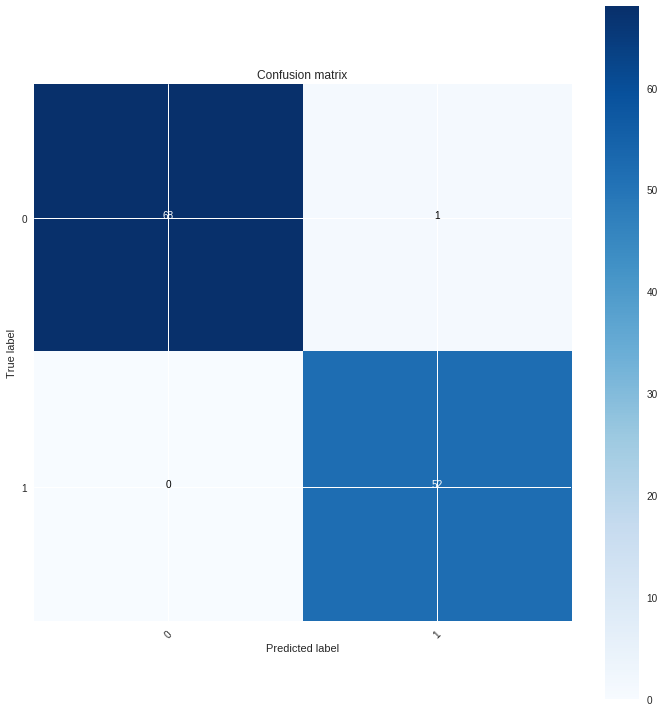

In [0]:
from sklearn.metrics import confusion_matrix

#Next, predict the class on validation data and generate the confusion_matrix
cm = confusion_matrix(y_test, pred_test)

#Now use the function above to plot it
np.set_printoptions(precision=3)
plt.figure(figsize = (10,10))
plot_confusion_matrix(cm, classes=range(2), normalize=False,
                      title='Confusion matrix')

plt.show()

In [12]:
#fit interpretable final model: max-depth 10, n_estimator 20
#import the decision tree module from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [13]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=20)

In [0]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
pred_test = rfc.predict(X_test)

In [0]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)


In [0]:
feature_importances.head(10)

,importance
DEPNDPYPNR,0.058207
PNRLWD3SX,0.037174
PNRLEMCTD_META,0.035736
ABODHER,0.029689
PNRLWDSMT,0.027290
UDPYPNR,0.024585
DEPNDPYILL,0.024035
ABUSEPYPNR,0.023091
PNRLEMCTD,0.021816
PNRNMWOUD,0.021165


In [14]:
filter_col = [col for col in X.columns if 'PNR' in col or 'HER' in col]
np.shape(filter_col)

(306,)

In [59]:
X_train.drop(filter_col, axis=1,inplace=True)
X_test.drop(filter_col, axis=1,inplace=True)


/Users/nhuang37/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/nhuang37/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
np.shape(X_train)

(51431, 4406)

In [61]:
#fit baseline DT on 4406 features
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [62]:
pred_test = clf.predict(X_test)
f1_score(y_test, pred_test)

0.9166666666666666

In [67]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [68]:
feature_importances.head(10)

,importance
UDPYPSY,0.621331
OPINMYR,0.129179
HRBSTWAY_META,0.061643
DEPNDPYIEM,0.035316
UDPYTRQ,0.022557
UDPYSTM,0.015117
HRNDLREC,0.012558
DEPNDPYPSY,0.006838
MORPPDPYMU,0.006752
TXLTYSEDV,0.005369


In [69]:
ct = pd.crosstab(df['OPINMYR'], df['UDPYOPI'], margins = False)
ct

UDPYOPI,0,1
OPINMYR,,
0,53877,3
1,2666,600


In [63]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# estimator = RandomForestClassifier(random_state=0, max_depth=5, n_estimators=20)

def show_learning_curve(estimator, title='Learning curve', scoring='f1',X=X,y=y):
    """Show learning curve.""" 
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, 
        X, y, train_sizes=np.linspace(500,40000,10).astype(int), cv=5, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel(scoring + ' score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training ' + scoring)
    plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Cross-validation ' + scoring)

    plt.legend(loc="best")
    plt.show()
    
    return train_sizes, train_scores, valid_scores

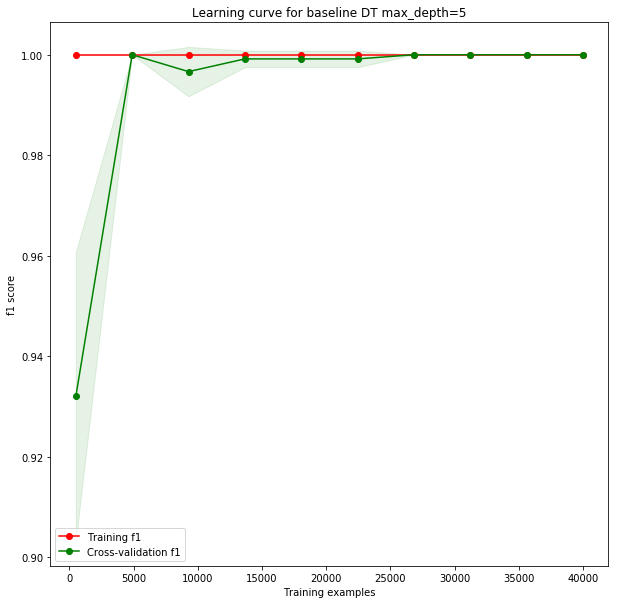

(array([  500,  4888,  9277, 13666, 18055, 22444, 26833, 31222, 35611,
        40000]), array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]), array([[0.98333333, 0.9339207 , 0.89497717, 0.92376682, 0.92376682],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 0.99585062, 1.        , 0.98734177, 1.        ],
        [1.        , 0.99585062, 1.        , 1.        , 1.        ],
        [1.        , 0.99585062, 1.        , 1.        , 1.        ],
        [1.        , 0.99585062, 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.     

In [66]:
show_learning_curve(DecisionTreeClassifier(random_state=0, max_depth=5),
                    title='Learning curve for baseline DT max_depth=5')

In [17]:
#fit RF on 4406 features
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
pred_test = rfc.predict_proba(X_test)

In [35]:
xmax, ymax = pred_test[y_test==1,:].argmax(axis=0)

In [36]:
xmax, ymax

(2, 45)

In [37]:
#most likely to be opioid abuser instance
pred_test[y_test==1,:][45]

array([0.15833333, 0.84166667])

In [0]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [0]:
feature_importances.head(10)

,importance
UDPYPSY,0.066771
DEPNDPYPSY,0.048577
UDPYIEM,0.034203
DEPNDPYILL,0.025353
OXYCPDPYMU,0.023520
OXCOPDPYMU,0.017213
UDPYILL,0.017002
DEPNDPYIEM,0.015212
ABODMRJ,0.013728
TXYRNDILL,0.011881


In [0]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# estimator = RandomForestClassifier(random_state=0, max_depth=5, n_estimators=20)

def show_learning_curve(estimator, title='Learning curve', scoring='f1',X=X,Y=Y):
    """Show learning curve.""" 
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, 
        X, Y, train_sizes=np.linspace(100,4000,10).astype(int), cv=5, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel(scoring + ' score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training ' + scoring)
    plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Cross-validation ' + scoring)

    plt.legend(loc="best")
    plt.show()
    
    return train_sizes, train_scores, valid_scores

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

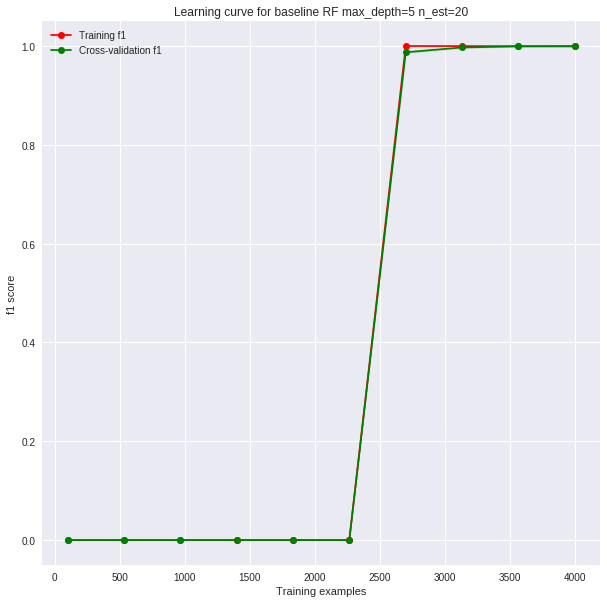

(array([ 100,  533,  966, 1400, 1833, 2266, 2700, 3133, 3566, 4000]),
 array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 0.99903754, 1.        , 1.        ],
        [0.99947562, 0.99947507, 1.        , 0.99947507, 1.        ],
        [0.99963964, 0.99963938, 1.        , 1.        , 1.        ]]),
 array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.       

In [0]:
show_learning_curve(RandomForestClassifier(random_state=0, max_depth=5, n_estimators=20),
                    title='Learning curve for baseline RF max_depth=5 n_est=20')

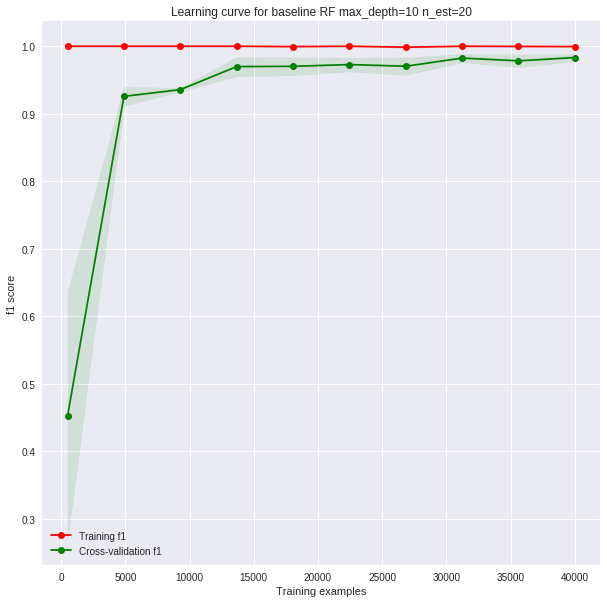

(array([  500,  4888,  9277, 13666, 18055, 22444, 26833, 31222, 35611,
        40000]),
 array([[1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [0.99746835, 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 0.99658703, 1.        , 0.99823633, 0.99823633],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 0.998713  , 1.        ],
        [1.        , 1.        , 1.        , 0.99883856, 0.99885189]]),
 array([[0.81967213, 0.38461538, 0.36842105, 0.32876712, 0.36241611],
        [0.94514768, 0.91555556, 0.92982456, 0.93333333, 0.90497738],
        [0.94117647, 0.93562232, 0.93449782, 0.9339207 , 0.93333333],


In [0]:
show_learning_curve(RandomForestClassifier(random_state=0, max_depth=10, n_estimators=20),
                    title='Learning curve for baseline RF max_depth=10 n_est=20')

In [0]:
rfc = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=20)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
for x in X.columns[np.argsort(rfc.feature_importances_)[-10:]]: print(x)

PNRNMWOUD
PNRLEMCTD
ABUSEPYPNR
DEPNDPYILL
UDPYPNR
PNRLWDSMT
ABODHER
PNRLEMCTD_META
PNRLWD3SX
DEPNDPYPNR


In [0]:
for x in np.sort(rfc.feature_importances_)[-10:]: print(x)

0.021165313759934024
0.021816434131349777
0.02309078887391041
0.024035480941547643
0.024584772222452273
0.0272898790888249
0.02968861761489373
0.03573571795657809
0.03717383467066261
0.058207075373250775


In [0]:
X_nopnr_her = X.drop([c for c in X.columns if "PNR" in c or "HER" in c], axis=1)

In [0]:
# X_nopnr_her.to_parquet(path_prefix + '/X_nopnr_her.parquet', compression='GZIP')
X_nopnr_her = pd.read_parquet(path_prefix + './X_nopnr_her.parquet')

In [0]:
rfc_nopnrher = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=20)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

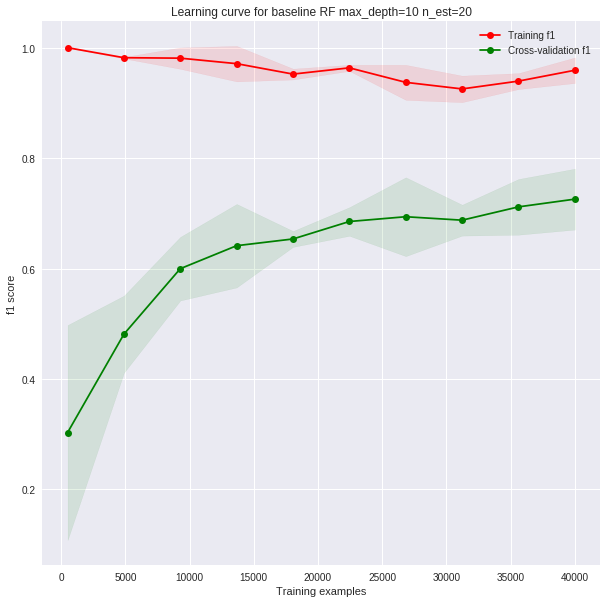

(array([  500,  4888,  9277, 13666, 18055, 22444, 26833, 31222, 35611,
        40000]),
 array([[1.        , 1.        , 1.        , 1.        , 1.        ],
        [0.98461538, 0.98113208, 0.98113208, 0.98113208, 0.98113208],
        [0.94240838, 0.99065421, 0.99065421, 0.99065421, 0.99065421],
        [0.91119691, 0.96323529, 0.99358974, 0.99358974, 0.99358974],
        [0.93261456, 0.95789474, 0.956743  , 0.956743  , 0.956743  ],
        [0.97435897, 0.95878525, 0.96137339, 0.96137339, 0.96137339],
        [0.95373665, 0.90093458, 0.89681051, 0.96727273, 0.96727273],
        [0.87788779, 0.93583725, 0.93081761, 0.94098884, 0.94098884],
        [0.93844049, 0.96395194, 0.91922006, 0.93442623, 0.94117647],
        [0.96634615, 0.97983393, 0.97005988, 0.96518607, 0.91407223]]),
 array([[0.69194313, 0.22068966, 0.20833333, 0.20143885, 0.19259259],
        [0.62      , 0.45086705, 0.45714286, 0.43902439, 0.43902439],
        [0.49425287, 0.65284974, 0.64321608, 0.62295082, 0.58563536],


In [0]:
show_learning_curve(RandomForestClassifier(random_state=0, max_depth=10, n_estimators=20),
                    title='Learning curve for baseline RF max_depth=10 n_est=20',X=X_nopnr_her,y=y)

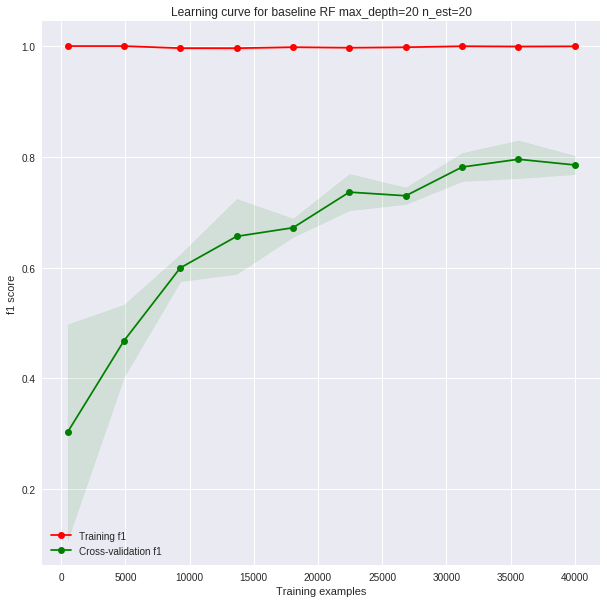

(array([  500,  4888,  9277, 13666, 18055, 22444, 26833, 31222, 35611,
        40000]),
 array([[1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 0.99534884, 0.99534884, 0.99534884, 0.99534884],
        [1.        , 1.        , 0.99358974, 0.99358974, 0.99358974],
        [0.99746835, 1.        , 0.99755501, 0.99755501, 0.99755501],
        [1.        , 0.997921  , 0.99585062, 0.99585062, 0.99585062],
        [1.        , 0.99829642, 0.99829642, 0.99646643, 0.99646643],
        [1.        , 0.99852725, 1.        , 1.        , 1.        ],
        [0.99870968, 0.99870968, 1.        , 1.        , 0.9986755 ],
        [1.        , 1.        , 0.99883586, 0.99883856, 1.        ]]),
 array([[0.69194313, 0.22068966, 0.20833333, 0.20143885, 0.19259259],
        [0.59487179, 0.45238095, 0.44311377, 0.44171779, 0.40740741],
        [0.60962567, 0.55681818, 0.61458333, 0.59090909, 0.62637363],


In [0]:
show_learning_curve(RandomForestClassifier(random_state=0, max_depth=20, n_estimators=20),
                    title='Learning curve for baseline RF max_depth=20 n_est=20',X=X_nopnr_her,y=y)

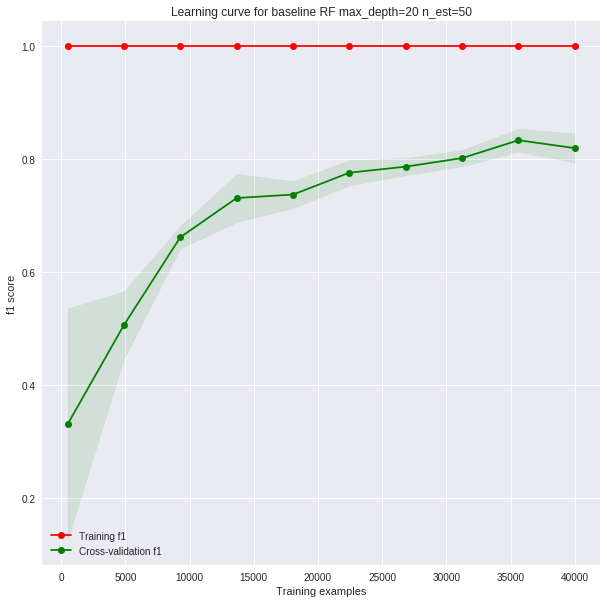

(array([  500,  4888,  9277, 13666, 18055, 22444, 26833, 31222, 35611,
        40000]), array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]), array([[0.73933649, 0.22377622, 0.25174825, 0.21582734, 0.22058824],
        [0.61139896, 0.45238095, 0.51497006, 0.5060241 , 0.44444444],
        [0.64285714, 0.65284974, 0.69607843, 0.64444444, 0.67015707],
        [0.71      , 0.65979381, 0.75829384, 0.78431373, 0.74146341],
        [0.7184466 , 0.71641791, 0.77934272, 0.74747475, 0.72277228],
        [0.8       , 0.73267327, 0.78222222, 0.77832512, 0.784689  ],
        [0.80373832, 0.7826087 , 0.80373832, 0.77669903, 0.76470588],
        [0.78341014, 0.79262673, 0.82142857, 0.81553398, 0.79425837],
        [0.86725664, 0.82352941, 0.8125    , 0.84507

In [0]:
show_learning_curve(RandomForestClassifier(random_state=0, max_depth=20, n_estimators=50),
                    title='Learning curve for baseline RF max_depth=20 n_est=50',X=X_nopnr_her,y=y)

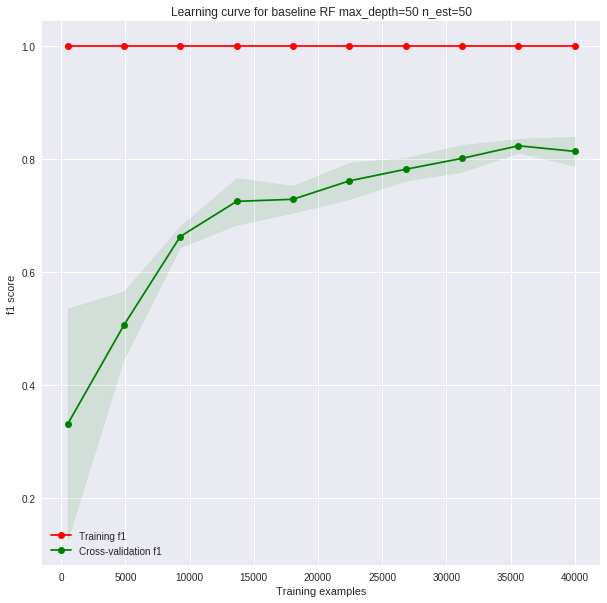

(array([  500,  4888,  9277, 13666, 18055, 22444, 26833, 31222, 35611,
        40000]), array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]), array([[0.73933649, 0.22377622, 0.25174825, 0.21582734, 0.22058824],
        [0.61139896, 0.45238095, 0.51497006, 0.5060241 , 0.44444444],
        [0.64974619, 0.65284974, 0.69607843, 0.64444444, 0.67015707],
        [0.70050761, 0.65968586, 0.74038462, 0.78217822, 0.74146341],
        [0.75238095, 0.70351759, 0.75471698, 0.73469388, 0.6974359 ],
        [0.81105991, 0.71      , 0.760181  , 0.75376884, 0.77073171],
        [0.79245283, 0.79425837, 0.80555556, 0.75      , 0.76616915],
        [0.79439252, 0.77358491, 0.84070796, 0.81372549, 0.7826087 ],
        [0.82727273, 0.82727273, 0.80357143, 0.84112

In [0]:
show_learning_curve(RandomForestClassifier(random_state=0, max_depth=50, n_estimators=50),
                    title='Learning curve for baseline RF max_depth=50 n_est=50',X=X_nopnr_her,y=y)

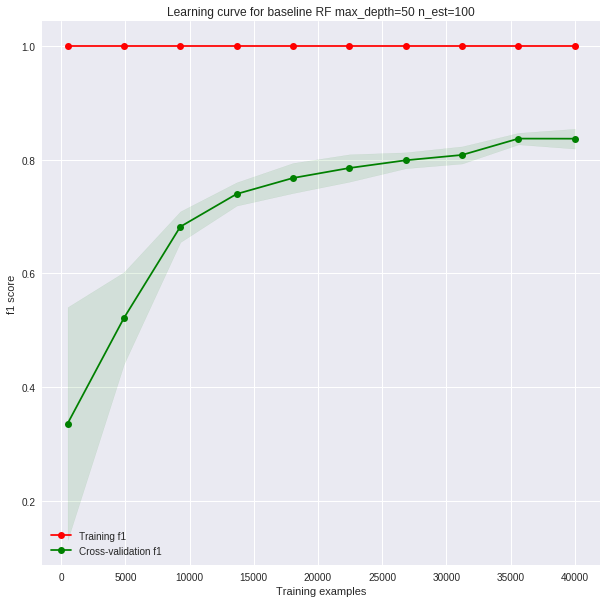

(array([  500,  4888,  9277, 13666, 18055, 22444, 26833, 31222, 35611,
        40000]), array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]), array([[0.73831776, 0.25      , 0.2972973 , 0.20143885, 0.19117647],
        [0.67980296, 0.48554913, 0.50299401, 0.48447205, 0.45398773],
        [0.68316832, 0.69651741, 0.70588235, 0.62983425, 0.69430052],
        [0.70243902, 0.73786408, 0.75      , 0.7638191 , 0.74371859],
        [0.79439252, 0.73786408, 0.80365297, 0.75621891, 0.74626866],
        [0.82949309, 0.75598086, 0.77981651, 0.77832512, 0.7826087 ],
        [0.81105991, 0.79620853, 0.81818182, 0.7804878 , 0.78817734],
        [0.82407407, 0.80542986, 0.82727273, 0.79207921, 0.79227053],
        [0.83035714, 0.84162896, 0.84304933, 0.84905

In [0]:
show_learning_curve(RandomForestClassifier(random_state=0, max_depth=50, n_estimators=100),
                    title='Learning curve for baseline RF max_depth=50 n_est=100',X=X_nopnr_her,y=y)

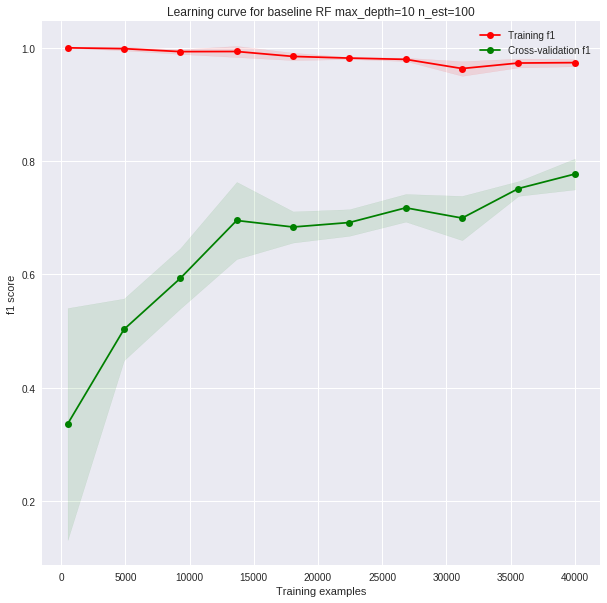

(array([  500,  4888,  9277, 13666, 18055, 22444, 26833, 31222, 35611,
        40000]),
 array([[1.        , 1.        , 1.        , 1.        , 1.        ],
        [0.99236641, 1.        , 1.        , 1.        , 1.        ],
        [0.98492462, 0.99534884, 0.99534884, 0.99534884, 0.99534884],
        [0.97454545, 0.99285714, 1.        , 1.        , 1.        ],
        [0.97674419, 0.97674419, 0.99014778, 0.99014778, 0.99014778],
        [0.9787234 , 0.98089172, 0.98319328, 0.98319328, 0.98319328],
        [0.9773913 , 0.97560976, 0.98445596, 0.98025135, 0.98025135],
        [0.96183206, 0.97897898, 0.97744361, 0.94936709, 0.94936709],
        [0.96395194, 0.98429319, 0.96533333, 0.97225892, 0.97975709],
        [0.97129187, 0.98584906, 0.97129187, 0.97380952, 0.96682464]]),
 array([[0.73831776, 0.25      , 0.2972973 , 0.20143885, 0.19117647],
        [0.60732984, 0.47058824, 0.46625767, 0.50617284, 0.46341463],
        [0.55434783, 0.65284974, 0.65625   , 0.57803468, 0.52325581],


In [0]:
show_learning_curve(RandomForestClassifier(random_state=0, max_depth=10, n_estimators=100),
                    title='Learning curve for baseline RF max_depth=10 n_est=100',X=X_nopnr_her,y=y)